In [1]:
from __future__ import print_function, division
from PIL import Image
from torchvision.utils import make_grid
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools

cudnn.benchmark = True
plt.ion()   # interactive mode

# Metrics of Embeddings

## Load embeddings

In [2]:
emb_dir = './embeddings'

models = ['resnet50', 'vgg11', 'alexnet']
labels = ['ants', 'bees', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [3]:
data = defaultdict(dict)
layer_names = {}
for model in models:
    layer_names[model] = np.load(os.path.join(emb_dir, model, 'layer_names.npy'))
    for label in labels:
        data[model][label] = np.load(os.path.join(emb_dir, model, label, 'embeddings.npy'))

In [4]:
data['resnet50']['tulips'].shape

(799, 7, 2048)

### Resnet

In [5]:
centers = defaultdict(dict)
R = defaultdict(dict)
# U = defaultdict(dict)

P = 500

for model in models:
    for label in labels:
        embeddings_per_layer = np.swapaxes(data[model][label][:P], 0, 1)
        center = embeddings_per_layer.mean(1)
        centers[model][label] = center
        _, s, _ = np.linalg.svd(embeddings_per_layer-center[:, None, :], full_matrices=False)
        R[model][label] = s
#         U[model][label]= u

In [6]:
R_squared_mean = defaultdict(dict)
D = defaultdict(dict)

for model in models:
    for label in labels:
        s = R[model][label]
        s_squared = np.square(s)
        R_squared_mean[model][label] = np.mean(s_squared, axis = 1)
        D[model][label] = np.square(np.sum(s_squared, axis = 1)) \
                        / np.sum(np.square(s_squared), axis = 1)
#         U[model][label]= u

In [7]:
R['resnet50']['tulips'].shape

(7, 500)

In [8]:
D['resnet50']['tulips']

array([ 19.80656 ,  31.544943,  97.175156, 186.36043 , 188.02513 ,
        28.581047,  28.897314], dtype=float32)

In [9]:
centers['resnet50']['ants'].shape

(7, 2048)

In [10]:
R['resnet50']['tulips'].shape

(7, 500)

In [11]:
layer_names['resnet50']

array(['input', 'conv1', 'layer2_bottleneck1', 'layer3_bottleneck1',
       'layer4_bottleneck1', 'avgpool', 'final'], dtype='<U18')

In [12]:
R_squared_mean['alexnet']['ants']

array([2692.555 , 2860.6812, 5660.6855, 6775.653 , 4494.457 , 1676.8483,
       5241.1367, 2364.672 ], dtype=float32)

## Distance between centroids

### Dandelions vs Tulips

order of magnitude increase in signal!

In [13]:
(np.linalg.norm(centers['resnet50']['tulips']-centers['resnet50']['dandelion'], axis = 1)**2)\
/R_squared_mean['resnet50']['dandelion']

array([0.05409306, 0.15373662, 0.11163736, 0.09912933, 0.12198698,
       0.48923504, 0.5125881 ], dtype=float32)

In [14]:
(np.linalg.norm(centers['resnet50']['tulips']-centers['resnet50']['dandelion'], axis = 1)**2)\
/R_squared_mean['resnet50']['tulips']

array([0.04649762, 0.09955359, 0.08615618, 0.07766833, 0.100885  ,
       0.4901208 , 0.5070671 ], dtype=float32)

In [15]:
layer_names['resnet50']

array(['input', 'conv1', 'layer2_bottleneck1', 'layer3_bottleneck1',
       'layer4_bottleneck1', 'avgpool', 'final'], dtype='<U18')

## Make Plots

In [16]:
labels
marker = itertools.cycle((',', '+', '.', 'o', '*')) 
color = itertools.cycle(('darkgoldenrod', 'slateblue', 'darkseagreen', 'rosybrown', 'teal', 'indianred')) 

In [17]:
R_squared_mean['resnet50']['ants']

array([2692.555   , 6192.8926  ,   44.81778 ,   31.792704,  149.25607 ,
        270.6921  ,  281.65247 ], dtype=float32)

### Radius

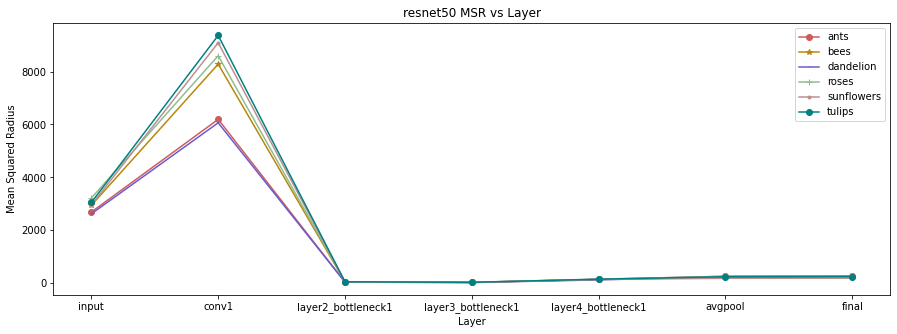

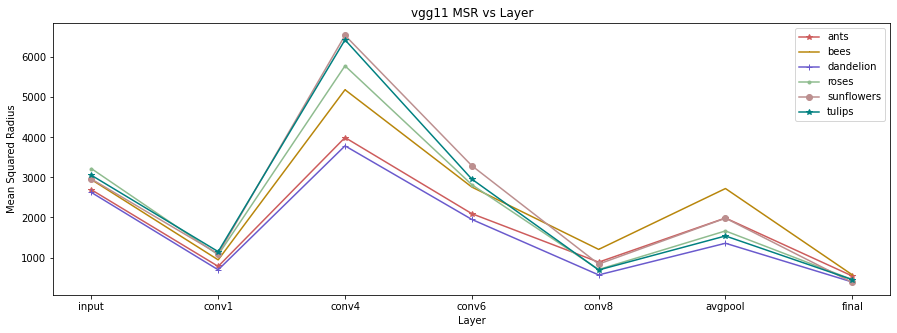

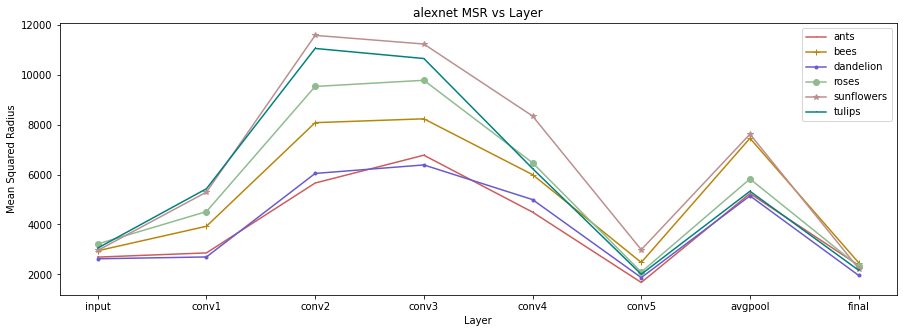

In [59]:
for model in models:
    plt.figure(figsize=(15,5))
    x = np.arange(len(layer_names[model]))
    for label in labels:
        plt.plot(x, R_squared_mean[model][label], label = label, color = next(color), marker = next(marker))
    my_xticks = layer_names[model]
    plt.xticks(x, my_xticks)
    plt.title(f'{model} MSR vs Layer')
    plt.xlabel("Layer")
    plt.ylabel("Mean Squared Radius")
    plt.legend()
    plt.savefig(f'{model}_radius.png')
    plt.show()

## Dimensionality

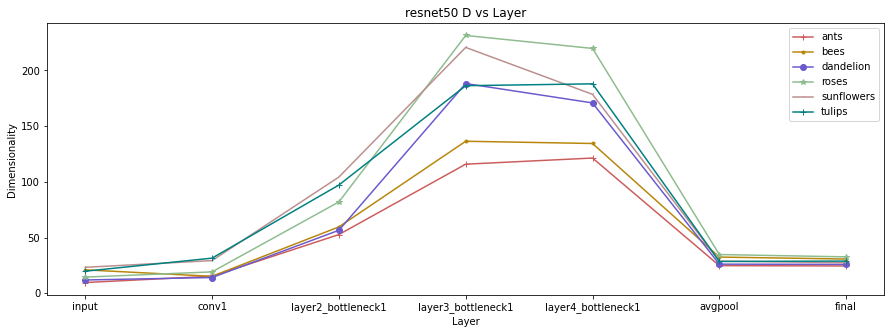

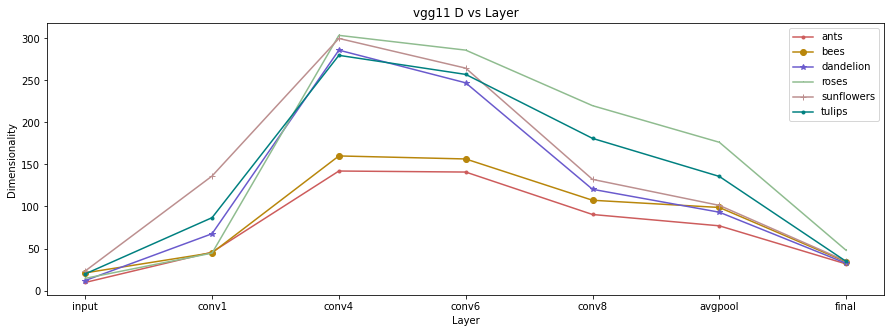

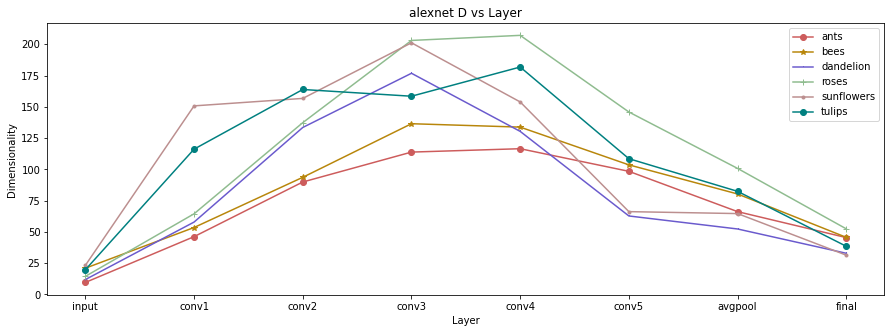

In [60]:
for model in models:
    x = np.arange(len(layer_names[model]))
    plt.figure(figsize=(15,5))
    for label in labels:
        plt.plot(x, D[model][label], label = label, color = next(color), marker = next(marker))
    my_xticks = layer_names[model]
    plt.xticks(x, my_xticks)
    plt.title(f'{model} D vs Layer')
    plt.xlabel("Layer")
    plt.ylabel("Dimensionality")
    plt.legend()
    plt.savefig(f'{model}_dimensionality.png')
    plt.show()

In [50]:
dimension_ratio = defaultdict(dict)

for model in models:
    for label in labels:
        dimension = D[model][label]
        dimension_ratio[model][label] = dimension[-1]/dimension[0]

In [51]:
dimension_ratio

defaultdict(dict,
            {'resnet50': {'ants': 2.5460348,
              'bees': 1.4615427,
              'dandelion': 2.1741757,
              'roses': 2.2535958,
              'sunflowers': 1.1778114,
              'tulips': 1.4589769},
             'vgg11': {'ants': 3.2814813,
              'bees': 1.6246022,
              'dandelion': 2.7186685,
              'roses': 3.2977865,
              'sunflowers': 1.5029706,
              'tulips': 1.7487949},
             'alexnet': {'ants': 4.7212415,
              'bees': 2.1723938,
              'dandelion': 2.7599506,
              'roses': 3.618027,
              'sunflowers': 1.348729,
              'tulips': 1.9454263}})

In [66]:
all_dimensionality = defaultdict(list)

for model in models:
    for label in labels:
        all_dimensionality[label].append(dimension_ratio[model][label])

In [67]:
all_dimensionality

defaultdict(list,
            {'ants': [2.5460348, 3.2814813, 4.7212415],
             'bees': [1.4615427, 1.6246022, 2.1723938],
             'dandelion': [2.1741757, 2.7186685, 2.7599506],
             'roses': [2.2535958, 3.2977865, 3.618027],
             'sunflowers': [1.1778114, 1.5029706, 1.348729],
             'tulips': [1.4589769, 1.7487949, 1.9454263]})

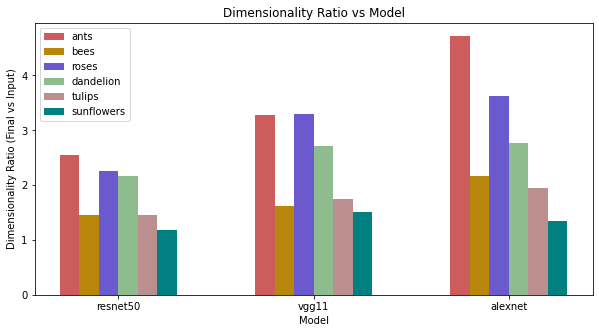

In [70]:
x = np.arange(len(models)) 
width = 0.1
plt.figure(figsize=(10,5))

plt.bar(x-0.25, all_dimensionality['ants'], width, color=next(color), label = 'ants')
plt.bar(x-0.15, all_dimensionality['bees'], width, color=next(color), label = 'bees')
plt.bar(x-0.05, all_dimensionality['roses'], width, color=next(color), label = 'roses')
plt.bar(x+0.05, all_dimensionality['dandelion'], width, color=next(color), label = 'dandelion')
plt.bar(x+0.15, all_dimensionality['tulips'], width, color=next(color), label = 'tulips')
plt.bar(x+0.25, all_dimensionality['sunflowers'], width, color=next(color), label = 'sunflowers')


my_xticks = models
plt.xticks(x, my_xticks)
plt.title(f'Dimensionality Ratio vs Model')
plt.xlabel("Model")
plt.ylabel("Dimensionality Ratio (Final vs Input)")
plt.legend()
plt.savefig('dimensionality_ratio.png')
plt.show()

## Signal 

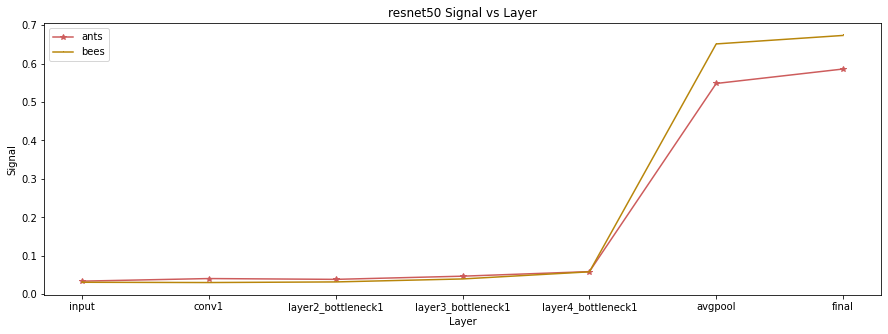

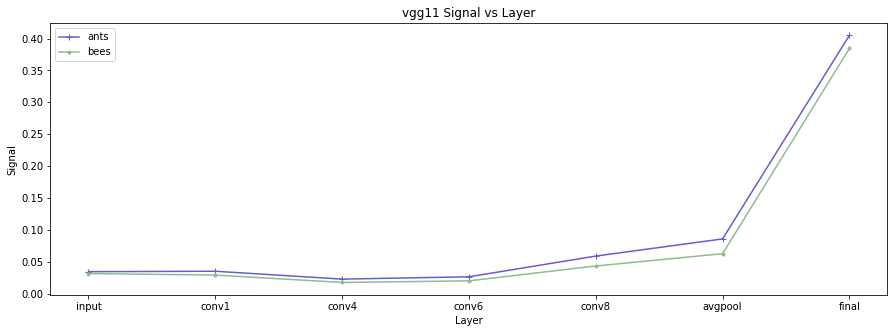

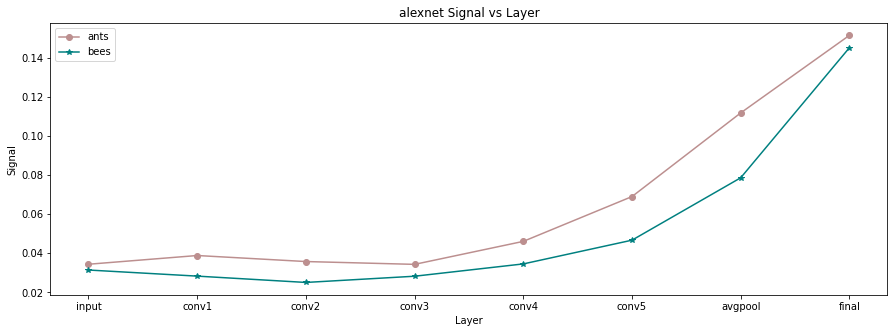

In [61]:
for model in models:
    x = np.arange(len(layer_names[model]))
    plt.figure(figsize=(15,5))
    for label in ['ants', 'bees']:
        signal = (np.linalg.norm(centers[model]['ants']-centers[model]['bees'], axis = 1)**2)\
/R_squared_mean[model][label]
        plt.plot(x, signal, label = label, color = next(color), marker = next(marker))
    my_xticks = layer_names[model]
    plt.xticks(x, my_xticks)
    plt.title(f'{model} Signal vs Layer')
    plt.xlabel("Layer")
    plt.ylabel("Signal")
    plt.legend()
    plt.savefig(f'{model}_signal_antsbees.png')
    plt.show()

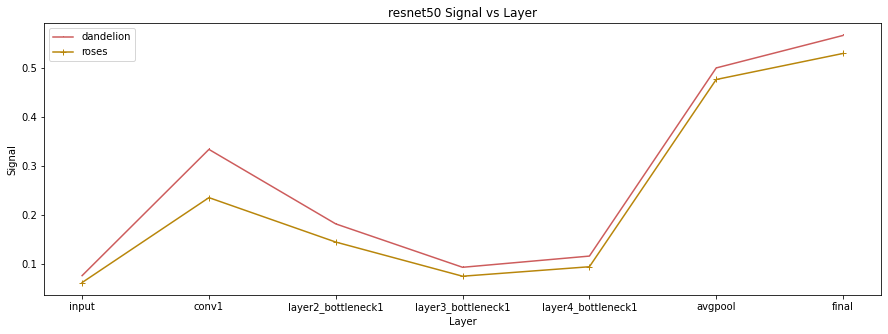

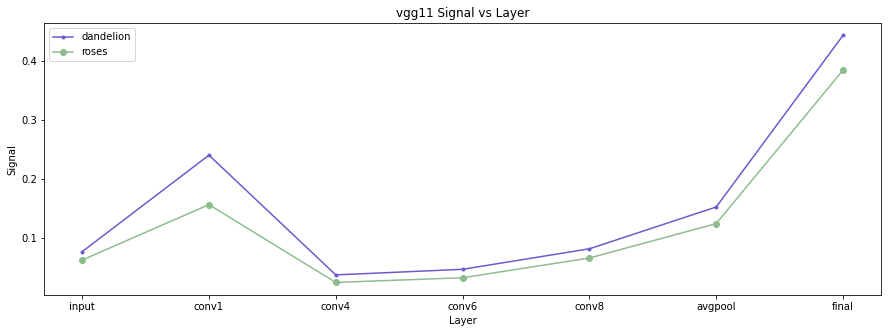

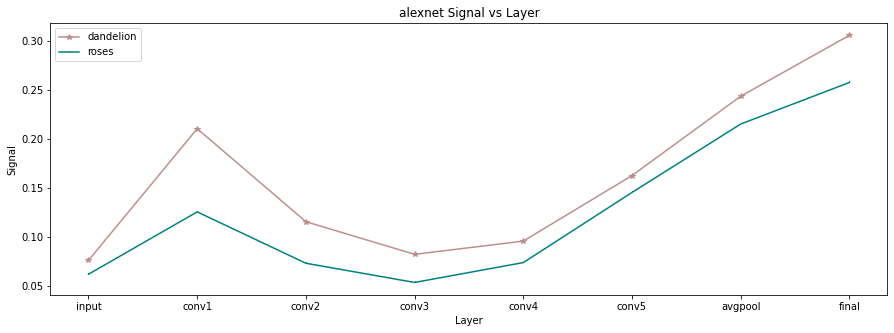

In [63]:
for model in models:
    x = np.arange(len(layer_names[model]))
    plt.figure(figsize=(15,5))
    
    signal = (np.linalg.norm(centers[model]['dandelion']-centers[model]['roses'], axis = 1)**2)\
/R_squared_mean[model]['dandelion']
    plt.plot(x, signal, label = 'dandelion', color = next(color), marker = next(marker))
    
    signal = (np.linalg.norm(centers[model]['dandelion']-centers[model]['roses'], axis = 1)**2)\
/R_squared_mean[model]['roses']
    plt.plot(x, signal, label = 'roses', color = next(color), marker = next(marker))
    
    my_xticks = layer_names[model]
    plt.xticks(x, my_xticks)
    plt.title(f'{model} Signal vs Layer')
    plt.xlabel("Layer")
    plt.ylabel("Signal")
    plt.legend()
    plt.savefig(f'{model}_signal_flowers.png')
    plt.show()

<Figure size 1080x360 with 0 Axes>

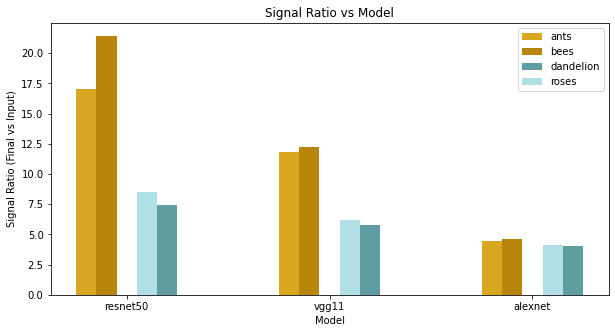

In [77]:
plt.figure(figsize=(15,5))

sig_ratio_antsbees = defaultdict(list)
sig_ratio_flowers = defaultdict(list)


for model in models:
    for label in ['ants', 'bees']:
        signal = (np.linalg.norm(centers[model]['ants']-centers[model]['bees'], axis = 1)**2)\
/R_squared_mean[model][label]
        sig_ratio_antsbees[label].append(signal[-1]/signal[0])
    for label in ['dandelion', 'roses']:
        signal = (np.linalg.norm(centers[model]['dandelion']-centers[model]['roses'], axis = 1)**2)\
/R_squared_mean[model][label]
        sig_ratio_flowers[label].append(signal[-1]/signal[0])

x = np.arange(len(models)) 
width = 0.1
plt.figure(figsize=(10,5))

plt.bar(x-0.2, sig_ratio_antsbees['ants'], width, color='goldenrod', label = 'ants')
plt.bar(x-0.1, sig_ratio_antsbees['bees'], width, color='darkgoldenrod', label = 'bees')

plt.bar(x+0.2, sig_ratio_flowers['dandelion'], width, color='cadetblue', label = 'dandelion')
plt.bar(x+0.1, sig_ratio_flowers['roses'], width, color='powderblue', label = 'roses')


my_xticks = models
plt.xticks(x, my_xticks)
plt.title(f'Signal Ratio vs Model')
plt.xlabel("Model")
plt.ylabel("Signal Ratio (Final vs Input)")
plt.legend()
plt.savefig('sigratio.png')
plt.show()

In [83]:
plt.figure(figsize=(15,5))

sig_ratio_antsbees = defaultdict(list)
sig_ratio_flowers = defaultdict(list)


for model in models:
    for label in ['sunflowers', 'tulips']:
        signal = (np.linalg.norm(centers[model]['sunflowers']-centers[model]['tulips'], axis = 1)**2)\
/R_squared_mean[model][label]
        sig_ratio_flowers[label].append(signal[-1]/signal[0])


<Figure size 1080x360 with 0 Axes>

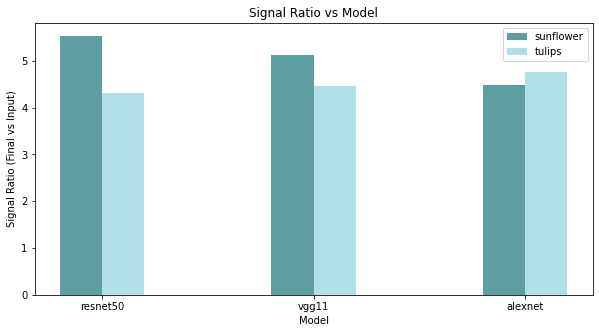

In [88]:
plt.figure(figsize=(10,5))
x = np.arange(len(models)) 
width = 0.2

plt.bar(x-0.1, sig_ratio_flowers['sunflowers'], width, color='cadetblue', label = 'sunflower')
plt.bar(x+0.1, sig_ratio_flowers['tulips'], width, color='powderblue', label = 'tulips')


my_xticks = models
plt.xticks(x, my_xticks)
plt.title(f'Signal Ratio vs Model')
plt.xlabel("Model")
plt.ylabel("Signal Ratio (Final vs Input)")
plt.legend()
plt.savefig('sigratio_sunflower_tulips.png')
plt.show()

In [82]:
sig_ratio_flowers

defaultdict(list,
            {'dandelion': [7.41108, 5.80421, 4.0008564],
             'roses': [8.500866, 6.1734576, 4.1364594],
             'sunflowers': []})

In [75]:
x

array([0, 1, 2])

In [79]:
np.arange(len(models)) 

array([0, 1, 2])